# Preliminary EDA and ARIMA modeling

### Imports

In [2]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
pd.set_option('display.max_columns', None)

### Read in all datasets

In [3]:
daily = pd.read_csv('./datasets/london_smart_meters/daily_dataset.csv')
acorn_details = pd.read_csv('./datasets/acorn_details.csv', encoding= 'unicode_escape')
household_info = pd.read_csv('./datasets/informations_households.csv')
holidays = pd.read_csv('./datasets/uk_bank_holidays.csv')
weather_daily = pd.read_csv('./datasets/weather_daily_darksky.csv')
weather_hourly = pd.read_csv('./datasets/weather_hourly_darksky.csv')

In [4]:
weather_daily.head()

,temperatureMax,temperatureMaxTime,windBearing,icon,dewPoint,temperatureMinTime,cloudCover,windSpeed,pressure,apparentTemperatureMinTime,apparentTemperatureHigh,precipType,visibility,humidity,apparentTemperatureHighTime,apparentTemperatureLow,apparentTemperatureMax,uvIndex,time,sunsetTime,temperatureLow,temperatureMin,temperatureHigh,sunriseTime,temperatureHighTime,uvIndexTime,summary,temperatureLowTime,apparentTemperatureMin,apparentTemperatureMaxTime,apparentTemperatureLowTime,moonPhase
0,11.96,2011-11-11 23:00:00,123,fog,9.40,2011-11-11 07:00:00,0.79,3.88,1016.08,2011-11-11 07:00:00,10.87,rain,3.30,0.95,2011-11-11 19:00:00,10.87,11.96,1.0,2011-11-11 00:00:00,2011-11-11 16:19:21,10.87,8.85,10.87,2011-11-11 07:12:14,2011-11-11 19:00:00,2011-11-11 11:00:00,Foggy until afternoon.,2011-11-11 19:00:00,6.48,2011-11-11 23:00:00,2011-11-11 19:00:00,0.52
1,8.59,2011-12-11 14:00:00,198,partly-cloudy-day,4.49,2011-12-11 01:00:00,0.56,3.94,1007.71,2011-12-11 02:00:00,5.62,rain,12.09,0.88,2011-12-11 19:00:00,-0.64,5.72,1.0,2011-12-11 00:00:00,2011-12-11 15:52:53,3.09,2.48,8.59,2011-12-11 07:57:02,2011-12-11 14:00:00,2011-12-11 12:00:00,Partly cloudy throughout the day.,2011-12-12 07:00:00,0.11,2011-12-11 20:00:00,2011-12-12 08:00:00,0.53
2,10.33,2011-12-27 02:00:00,225,partly-cloudy-day,5.47,2011-12-27 23:00:00,0.85,3.54,1032.76,2011-12-27 22:00:00,10.33,rain,13.39,0.74,2011-12-27 14:00:00,5.52,10.33,0.0,2011-12-27 00:00:00,2011-12-27 15:57:56,8.03,8.03,10.33,2011-12-27 08:07:06,2011-12-27 14:00:00,2011-12-27 00:00:00,Mostly cloudy throughout the day.,2011-12-27 23:00:00,5.59,2011-12-27 02:00:00,2011-12-28 00:00:00,0.10
3,8.07,2011-12-02 23:00:00,232,wind,3.69,2011-12-02 07:00:00,0.32,3.00,1012.12,2011-12-02 07:00:00,5.33,rain,11.89,0.87,2011-12-02 12:00:00,3.26,5.33,1.0,2011-12-02 00:00:00,2011-12-02 15:56:17,6.33,2.56,7.36,2011-12-02 07:46:09,2011-12-02 12:00:00,2011-12-02 10:00:00,Partly cloudy throughout the day and breezy ov...,2011-12-02 19:00:00,0.46,2011-12-02 12:00:00,2011-12-02 19:00:00,0.25
4,8.22,2011-12-24 23:00:00,252,partly-cloudy-night,2.79,2011-12-24 07:00:00,0.37,4.46,1028.17,2011-12-24 07:00:00,5.02,rain,13.16,0.80,2011-12-24 15:00:00,4.37,5.32,1.0,2011-12-24 00:00:00,2011-12-24 15:55:55,7.45,3.17,7.93,2011-12-24 08:06:15,2011-12-24 15:00:00,2011-12-24 13:00:00,Mostly cloudy throughout the day.,2011-12-24 19:00:00,-0.51,2011-12-24 23:00:00,2011-12-24 20:00:00,0.99


In [212]:
daily['day'] = pd.to_datetime(daily['day'])

In [213]:
daily.head()

,LCLid,day,energy_median,energy_mean,energy_max,energy_count,energy_std,energy_sum,energy_min
0,MAC000131,2011-12-15,0.4850,0.432045,0.868,22,0.239146,9.505,0.072
1,MAC000131,2011-12-16,0.1415,0.296167,1.116,48,0.281471,14.216,0.031
2,MAC000131,2011-12-17,0.1015,0.189812,0.685,48,0.188405,9.111,0.064
3,MAC000131,2011-12-18,0.1140,0.218979,0.676,48,0.202919,10.511,0.065
4,MAC000131,2011-12-19,0.1910,0.325979,0.788,48,0.259205,15.647,0.066


### Aggregate data into the daily sum across households

In [214]:
ds = daily.groupby(by='day').sum()

In [215]:
ds.head()

,energy_median,energy_mean,energy_max,energy_count,energy_std,energy_sum,energy_min
day,,,,,,,
2011-11-23,2.9660,3.654184,9.835,334,2.264165,90.385000,1.113
2011-11-24,4.8395,5.855170,19.046,922,3.909215,213.412000,2.019
2011-11-25,5.6890,7.196841,23.246,1383,4.962879,303.993000,2.283
2011-11-26,8.3345,10.153053,33.868,1773,7.115718,420.976000,3.002
2011-11-27,7.4235,9.268396,35.484,1968,7.180928,444.883001,2.867


### Plot each of the columns in daily

In [216]:
def plot_series(df, cols=None, title='Title', xlab=None, ylab=None): #, steps=1):
    
    plt.figure(figsize=(9, 6))
    
    # Iterate through each column name.
    for col in cols:
        df[col].plot()
    plt.legend()    
    
    # Generate title and labels.
    plt.title(title, fontsize=13)
    plt.xlabel(xlab, fontsize=11)
    plt.ylabel(ylab, fontsize=11)
    
    # Enlarge tick marks.
    #plt.yticks(fontsize=18)
    #plt.xticks(df.index[0::steps], fontsize=18);

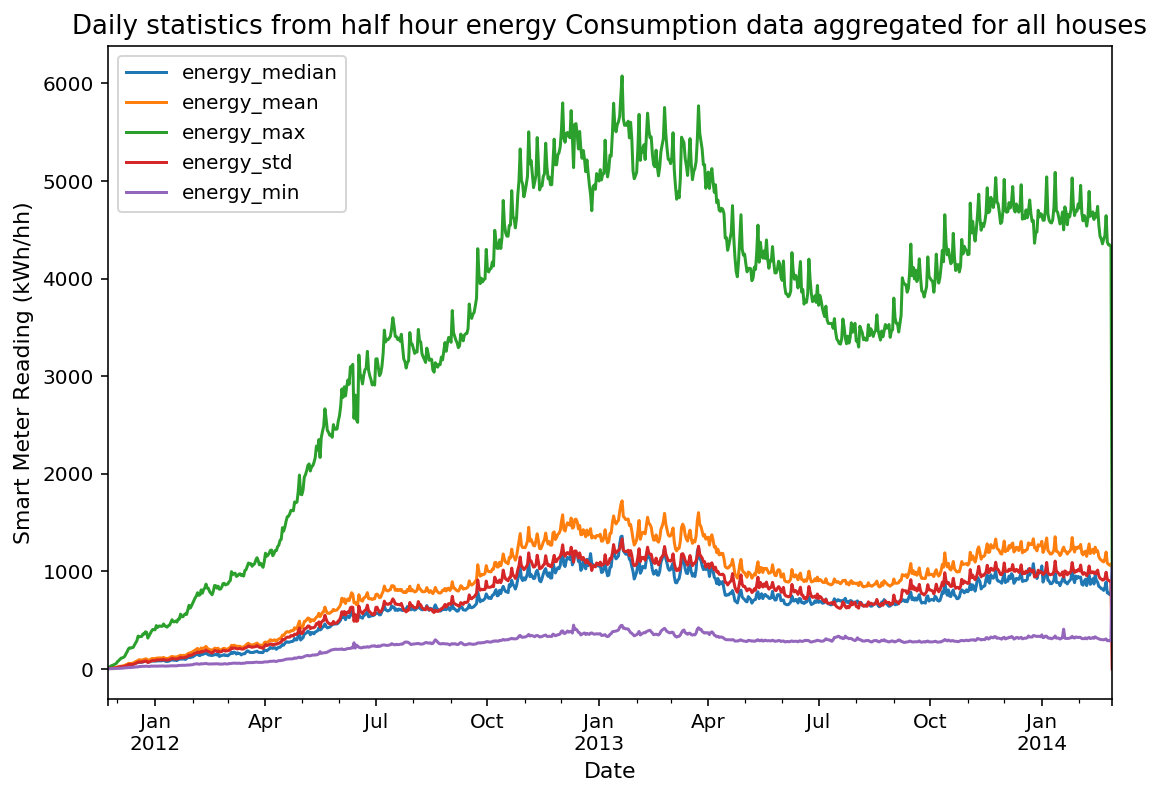

In [217]:
plot_series(df = ds, 
            cols = ds.columns.drop(['energy_count', 'energy_sum']), 
            title = 'Daily statistics from half hour energy Consumption data aggregated for all houses', 
            xlab = 'Date',
            ylab = 'Smart Meter Reading (kWh/hh)')
            

**Plot the measurement counts to try to see why energy usage is so low for the first year**

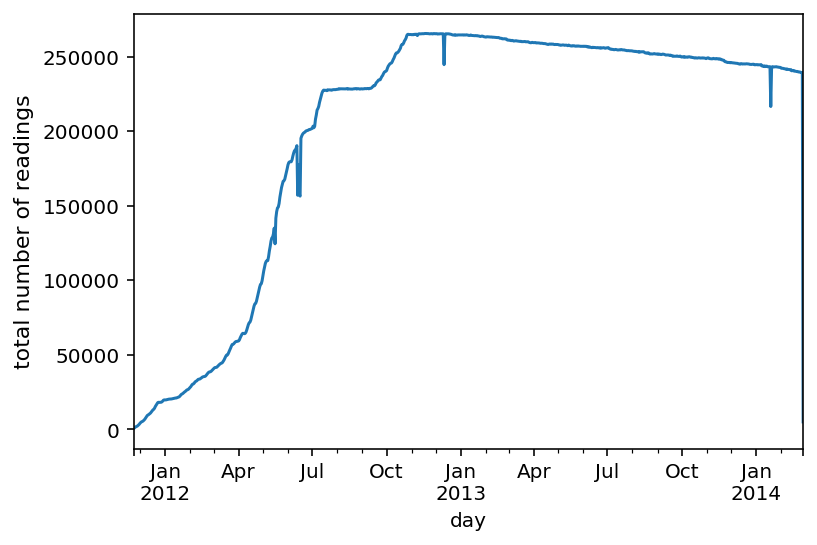

In [218]:
ds['energy_count'].plot()
plt.ylabel('total number of readings', fontsize=11);

In [219]:
daily.isnull().sum()

LCLid                0
day                  0
energy_median       30
energy_mean         30
energy_max          30
energy_count         0
energy_std       11331
energy_sum          30
energy_min          30
dtype: int64

In [220]:
ds.isnull().sum()

energy_median    0
energy_mean      0
energy_max       0
energy_count     0
energy_std       0
energy_sum       0
energy_min       0
dtype: int64

#### It appears as though some houses have no readings for the first year or so. I will pick one house that has readings for all dates and plot its consumption. 

#### First get rid of any houses with few readings less than 100

In [221]:
daily_reading_sum = daily.groupby(by = 'LCLid').sum().sort_values(by='energy_count',ascending=False)
daily_reading_sum.tail(7)

,energy_median,energy_mean,energy_max,energy_count,energy_std,energy_sum,energy_min
LCLid,,,,,,,
MAC001300,1.4525,1.902115,8.832,359,1.648967,79.725,0.502
MAC005565,0.1790,0.260611,1.242,44,0.303827,5.790,0.062
MAC005556,0.0000,0.000000,0.000,0,0.000000,0.000,0.000
MAC005559,0.0000,0.000000,0.000,0,0.000000,0.000,0.000
MAC005560,0.0000,0.000000,0.000,0,0.000000,0.000,0.000
MAC001150,0.0000,0.000000,0.000,0,0.000000,0.000,0.000
MAC005563,0.0000,0.000000,0.000,0,0.000000,0.000,0.000


In [222]:
no_readings = list(daily_reading_sum.loc[daily_reading_sum['energy_count'] < 100].index)

In [223]:
for house in no_readings:
    daily = daily.loc[daily['LCLid'] != house, :]

### Plot the energy usage for the house with the highest energy count

In [224]:
house_0 = 'MAC000145'
single_house_daily = daily.loc[daily['LCLid']==house_0, :]
single_house_daily.set_index('day', inplace=True)

In [225]:
single_house_daily.head()

,LCLid,energy_median,energy_mean,energy_max,energy_count,energy_std,energy_sum,energy_min
day,,,,,,,,
2011-11-23,MAC000145,0.2575,0.298400,0.928,30,0.166282,8.952,0.094
2011-11-24,MAC000145,0.2250,0.252812,0.625,48,0.135267,12.135,0.092
2011-11-25,MAC000145,0.2405,0.285833,1.020,48,0.165789,13.720,0.134
2011-11-26,MAC000145,0.2900,0.317375,0.845,48,0.138187,15.234,0.137
2011-11-27,MAC000145,0.2485,0.274771,0.777,48,0.172795,13.189,0.066


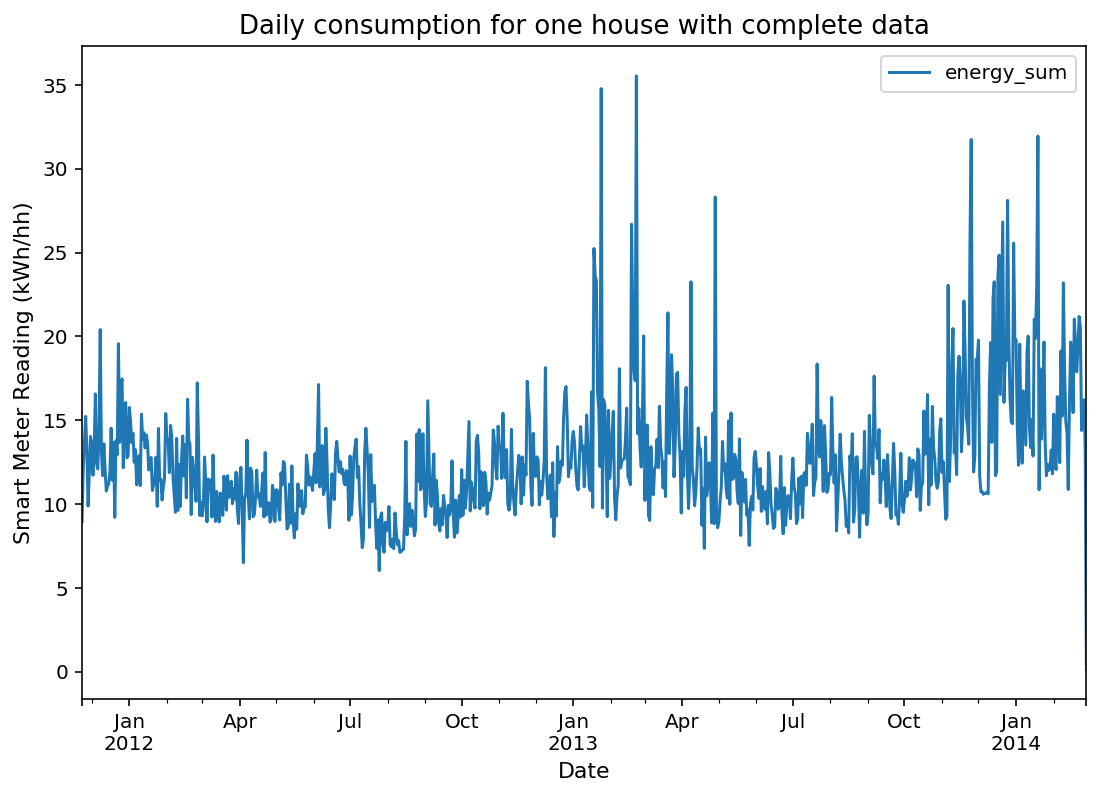

In [226]:
plot_series(df = single_house_daily,
            cols = ['energy_sum'], #single_house_daily.columns.drop(['LCLid', 'energy_count', 'energy_sum']),
            title = 'Daily consumption for one house with complete data', 
            xlab = 'Date',
            ylab = 'Smart Meter Reading (kWh/hh)')

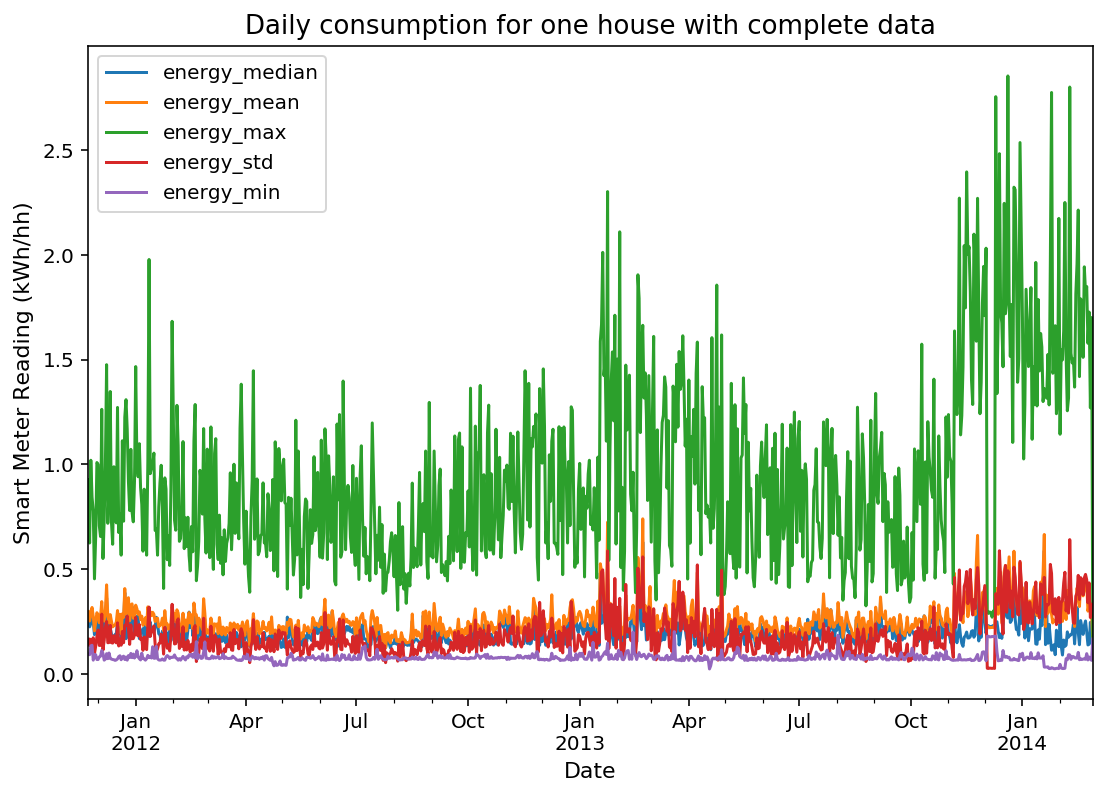

In [227]:
plot_series(df = single_house_daily,
            cols = single_house_daily.columns.drop(['LCLid', 'energy_count', 'energy_sum']),
            title = 'Daily consumption for one house with complete data', 
            xlab = 'Date',
            ylab = 'Smart Meter Reading (kWh/hh)')

### Try implementing an ARIMA model on this house's energy sum

**First check for stationarity using the ADF test**

In [228]:
def interpret_dftest(dftest):
    dfoutput = pd.Series(dftest[0:2], index=['Test Statistic','p-value'])
    return dfoutput

interpret_dftest(adfuller(single_house_daily['energy_sum']))

Test Statistic   -5.217984
p-value           0.000008
dtype: float64

The p-value is below 0.05, I will move forward assuming that the data is stationary

**Generate an auto and partial correlation plot**

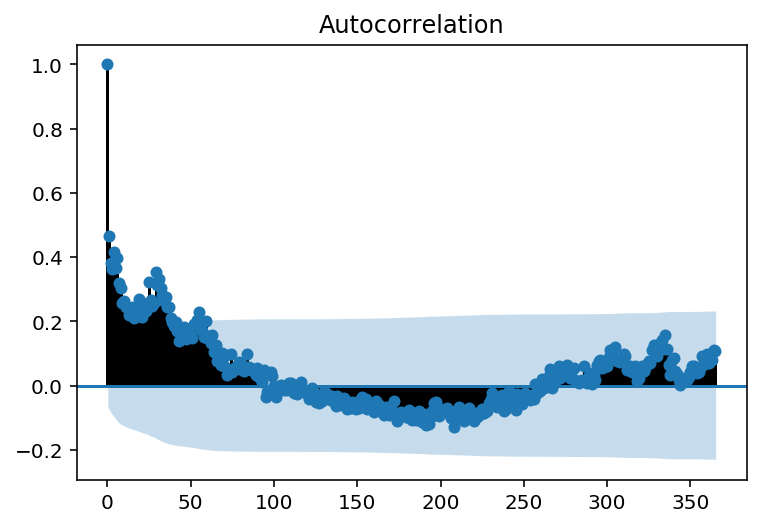

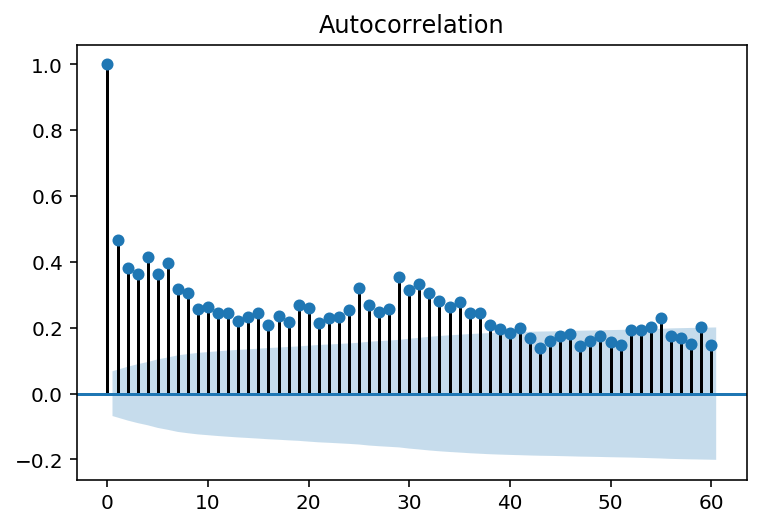

In [229]:
plot_acf(single_house_daily['energy_sum'], lags=365);
plot_acf(single_house_daily['energy_sum'], lags = 60);

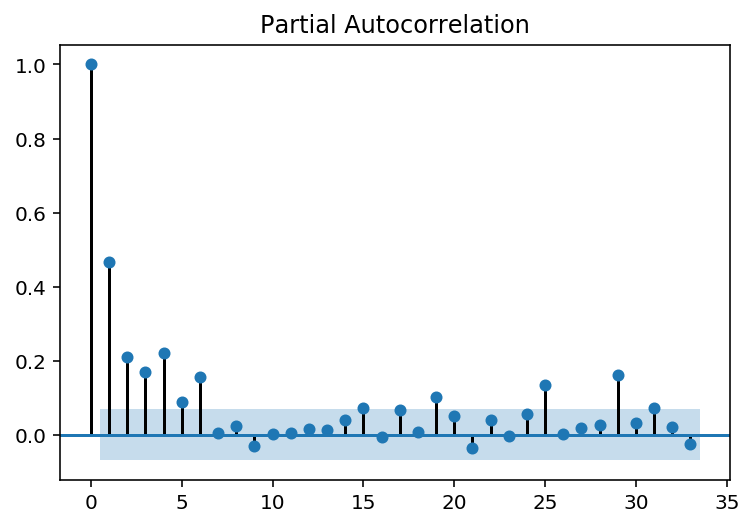

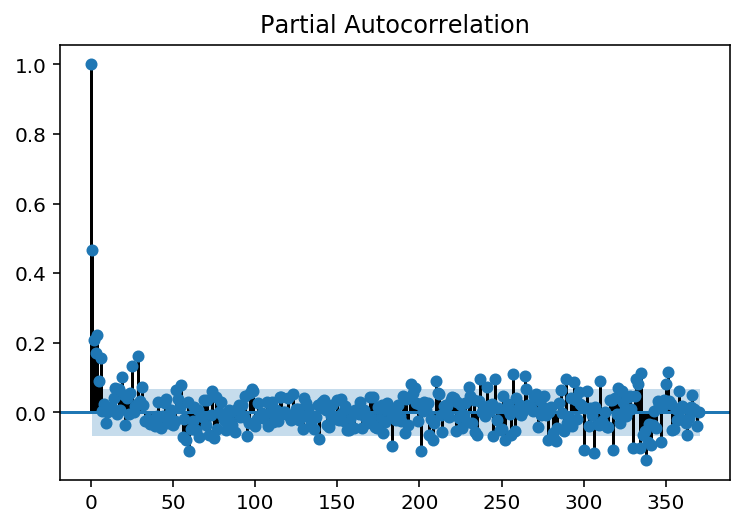

In [230]:
plot_pacf(single_house_daily['energy_sum'], lags = 33);
plot_pacf(single_house_daily['energy_sum'], lags = 370);

From the pacf, the first 6 days and the 19, 25, and 29th all could be significant seasonal variables, as well as a multiple lags later in the year.

### Train test split

In [231]:
y_train, y_test = train_test_split(single_house_daily['energy_sum'],
                                   test_size = 0.1,
                                   shuffle = False)

### Fit ARIMA

In [232]:
model = ARIMA(endog = y_train.dropna(), 
              order = (3,0,3))

arima = model.fit()

preds = model.predict(params = arima.params, 
                      start = y_test.index[0],
                      end = y_test.index[-1])

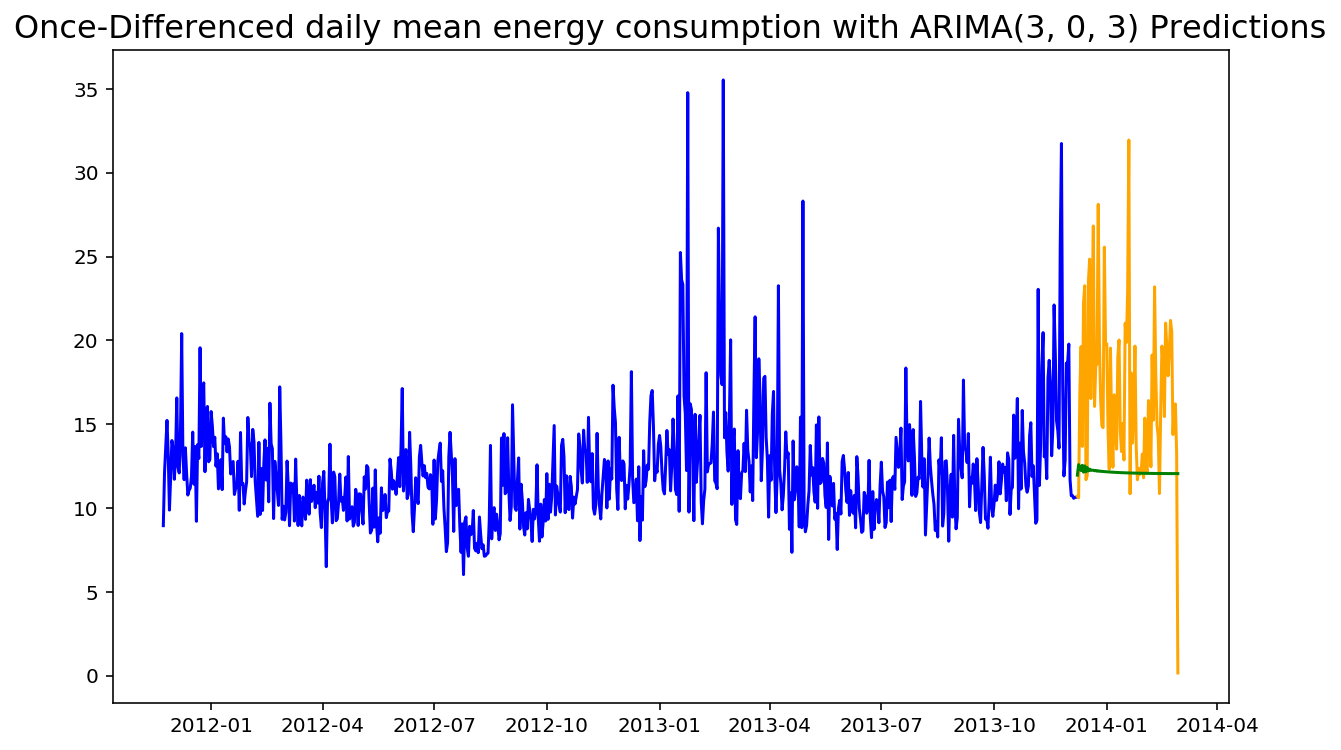

In [233]:
# Plot data.
plt.figure(figsize=(10,6))

# Plot training data.
plt.plot(y_train.index, pd.DataFrame(y_train), color = 'blue')

# Plot testing data.
plt.plot(y_test.index, pd.DataFrame(y_test), color = 'orange')

# Plot predicted test values.
plt.plot(y_test.index, preds, color = 'green')

plt.title(label = 'Once-Differenced daily mean energy consumption with ARIMA(3, 0, 3) Predictions', fontsize=16)
plt.show();

#### The ARIMA model did very poorly as expected, the next model, an RNN will be applied in the next notebook

## Create a master dataframe of daily data sums and daily data with acorn info

**24 houses are missing data mostly for the same day in december 2012, drop these houses**

In [234]:
daily.isnull().sum()

LCLid                0
day                  0
energy_median       24
energy_mean         24
energy_max          24
energy_count         0
energy_std       11325
energy_sum          24
energy_min          24
dtype: int64

In [235]:
for house in list(daily.loc[daily['energy_median'].isnull(),:]['LCLid']):
    daily = daily.loc[daily['LCLid'] != house, :].copy()

In [236]:
master_daily = pd.merge(daily, household_info)

In [237]:
master_ds = daily.groupby(by='day').sum()

In [238]:
master_ds.head(2)

,energy_median,energy_mean,energy_max,energy_count,energy_std,energy_sum,energy_min
day,,,,,,,
2011-11-23,2.9660,3.654184,9.835,334,2.264165,90.385,1.113
2011-11-24,4.8395,5.855170,19.046,922,3.909215,213.412,2.019


In [239]:
master_daily.head()

,LCLid,day,energy_median,energy_mean,energy_max,energy_count,energy_std,energy_sum,energy_min,stdorToU,Acorn,Acorn_grouped,file
0,MAC000131,2011-12-15,0.4850,0.432045,0.868,22,0.239146,9.505,0.072,Std,ACORN-E,Affluent,block_22
1,MAC000131,2011-12-16,0.1415,0.296167,1.116,48,0.281471,14.216,0.031,Std,ACORN-E,Affluent,block_22
2,MAC000131,2011-12-17,0.1015,0.189812,0.685,48,0.188405,9.111,0.064,Std,ACORN-E,Affluent,block_22
3,MAC000131,2011-12-18,0.1140,0.218979,0.676,48,0.202919,10.511,0.065,Std,ACORN-E,Affluent,block_22
4,MAC000131,2011-12-19,0.1910,0.325979,0.788,48,0.259205,15.647,0.066,Std,ACORN-E,Affluent,block_22


In [240]:
master_daily['day'] = pd.to_datetime(master_daily['day'])

In [241]:
master_daily.set_index('day', inplace=True)

#### merge in the weather data points

In [242]:
weather_daily.head(2)

,temperatureMax,temperatureMaxTime,windBearing,icon,dewPoint,temperatureMinTime,cloudCover,windSpeed,pressure,apparentTemperatureMinTime,apparentTemperatureHigh,precipType,visibility,humidity,apparentTemperatureHighTime,apparentTemperatureLow,apparentTemperatureMax,uvIndex,time,sunsetTime,temperatureLow,temperatureMin,temperatureHigh,sunriseTime,temperatureHighTime,uvIndexTime,summary,temperatureLowTime,apparentTemperatureMin,apparentTemperatureMaxTime,apparentTemperatureLowTime,moonPhase
0,11.96,2011-11-11 23:00:00,123,fog,9.40,2011-11-11 07:00:00,0.79,3.88,1016.08,2011-11-11 07:00:00,10.87,rain,3.30,0.95,2011-11-11 19:00:00,10.87,11.96,1.0,2011-11-11 00:00:00,2011-11-11 16:19:21,10.87,8.85,10.87,2011-11-11 07:12:14,2011-11-11 19:00:00,2011-11-11 11:00:00,Foggy until afternoon.,2011-11-11 19:00:00,6.48,2011-11-11 23:00:00,2011-11-11 19:00:00,0.52
1,8.59,2011-12-11 14:00:00,198,partly-cloudy-day,4.49,2011-12-11 01:00:00,0.56,3.94,1007.71,2011-12-11 02:00:00,5.62,rain,12.09,0.88,2011-12-11 19:00:00,-0.64,5.72,1.0,2011-12-11 00:00:00,2011-12-11 15:52:53,3.09,2.48,8.59,2011-12-11 07:57:02,2011-12-11 14:00:00,2011-12-11 12:00:00,Partly cloudy throughout the day.,2011-12-12 07:00:00,0.11,2011-12-11 20:00:00,2011-12-12 08:00:00,0.53


In [243]:
# fix the time missalignment
weather_daily['day'] = weather_daily['time'].str.replace('23:00:00', '00:00:00')
# set day to be the index for the weather data so it can be merged
weather_daily['day'] = pd.to_datetime(weather_daily['day'])
weather_daily.set_index('day', inplace=True)

In [245]:
# create master data frame
master_daily = pd.merge(master_daily, weather_daily.loc[:, ['temperatureMax', 'temperatureLow', 'windSpeed', 'cloudCover', 'humidity', 'visibility']], left_index=True, right_index=True, how='left')

In [246]:
master_ds = pd.merge(master_ds, weather_daily.loc[:, ['temperatureMax', 'temperatureLow', 'windSpeed', 'cloudCover', 'humidity', 'visibility']], left_index=True, right_index=True, how='left')


In [251]:
master_ds.isnull().sum()

energy_median     0
energy_mean       0
energy_max        0
energy_count      0
energy_std        0
energy_sum        0
energy_min        0
temperatureMax    2
temperatureLow    2
windSpeed         2
cloudCover        3
humidity          2
visibility        2
dtype: int64

#### Fix the weather nulls

In [252]:
null_list = ['temperatureMax', 'temperatureLow', 'windSpeed', 'cloudCover', 'humidity', 'visibility']

In [249]:
for i in master_ds.loc[master_ds['temperatureMax'].isnull(),:].index:
    print(i)

2012-10-28 00:00:00
2013-10-27 00:00:00


In [267]:
for feature in null_list:
    master_ds.loc[master_ds.index == '2012-10-28 00:00:00', feature] = list(master_ds.loc[master_ds.index == '2012-10-27 00:00:00', feature])[0]
    master_ds.loc[master_ds.index == '2013-10-27 00:00:00', feature] = list(master_ds.loc[master_ds.index == '2013-10-26 00:00:00', feature])[0]

In [269]:
master_ds.loc[master_ds['cloudCover'].isnull(), 'cloudCover'] = master_ds['cloudCover'].mean()

In [270]:
master_ds.isnull().sum()

energy_median     0
energy_mean       0
energy_max        0
energy_count      0
energy_std        0
energy_sum        0
energy_min        0
temperatureMax    0
temperatureLow    0
windSpeed         0
cloudCover        0
humidity          0
visibility        0
dtype: int64

#### Adjust holiday data frame to merge with master

In [271]:
holidays.head()

,Bank holidays,Type
0,2012-12-26,Boxing Day
1,2012-12-25,Christmas Day
2,2012-08-27,Summer bank holiday
3,2012-05-06,Queen?s Diamond Jubilee (extra bank holiday)
4,2012-04-06,Spring bank holiday (substitute day)


In [272]:
holidays['holiday'] = holidays['Type']
holidays['date'] = pd.to_datetime(holidays['Bank holidays'])
holidays.set_index('date', inplace=True)
holidays.drop(columns=['Bank holidays', 'Type'], inplace=True)

#### Add a column labeling holidays

In [273]:
holidays.head()

,holiday
date,
2012-12-26,Boxing Day
2012-12-25,Christmas Day
2012-08-27,Summer bank holiday
2012-05-06,Queen?s Diamond Jubilee (extra bank holiday)
2012-04-06,Spring bank holiday (substitute day)


In [190]:
import warnings
warnings.simplefilter(action="ignore")

master_daily['holiday'] = 0

for i in list(holidays.index):
    for j, k in enumerate(list(master_daily.index)):
        if i == k:
            master_daily['holiday'][j] = 1


In [191]:
holiday_list = np.array(master_daily['holiday'])

In [192]:
master_daily['holiday'].value_counts()

0    3424812
1      80530
Name: holiday, dtype: int64

In [274]:
master_ds.head()

,energy_median,energy_mean,energy_max,energy_count,energy_std,energy_sum,energy_min,temperatureMax,temperatureLow,windSpeed,cloudCover,humidity,visibility
day,,,,,,,,,,,,,
2011-11-23,2.9660,3.654184,9.835,334,2.264165,90.385000,1.113,10.36,8.24,2.04,0.36,0.93,8.06
2011-11-24,4.8395,5.855170,19.046,922,3.909215,213.412000,2.019,12.93,9.71,4.04,0.41,0.89,10.64
2011-11-25,5.6890,7.196841,23.246,1383,4.962879,303.993000,2.283,13.03,7.01,5.02,0.48,0.79,12.38
2011-11-26,8.3345,10.153053,33.868,1773,7.115718,420.976000,3.002,12.96,11.59,5.75,0.44,0.81,13.07
2011-11-27,7.4235,9.268396,35.484,1968,7.180928,444.883001,2.867,13.54,1.31,5.48,0.42,0.72,13.08


In [275]:
master_ds = pd.merge(master_ds, holidays, left_index=True, right_index=True, how='left')
master_ds['day_off'] = master_ds['holiday']

In [276]:
master_ds['holiday'] = np.where(master_ds['day_off'].isnull(), 0, 1)

In [277]:
master_ds.drop(columns='day_off', inplace=True)

In [278]:
master_ds.isnull().sum()

energy_median     0
energy_mean       0
energy_max        0
energy_count      0
energy_std        0
energy_sum        0
energy_min        0
temperatureMax    0
temperatureLow    0
windSpeed         0
cloudCover        0
humidity          0
visibility        0
holiday           0
dtype: int64

In [198]:
master_daily.isnull().sum()

LCLid                   0
energy_median           0
energy_mean             0
energy_max              0
energy_count            0
energy_std          11280
energy_sum              0
energy_min              0
stdorToU                0
Acorn                   0
Acorn_grouped           0
file                    0
temperatureMax    1960103
temperatureLow    1960103
windSpeed         1960103
cloudCover        1965194
humidity          1960103
visibility        1960103
holiday                 0
dtype: int64

### Make the tax column numeric

In [279]:
master_daily['stdorToU'].value_counts()

Std    2804907
ToU     707027
Name: stdorToU, dtype: int64

In [200]:
master_daily['tax'] = np.where(master_daily['stdorToU'] == 'ToU', 1, 0)
master_daily.drop(columns='stdorToU', inplace=True)

**Drop rows where the acorn is incorrectly labeled ACORN -**

In [201]:
master_daily.shape

(3505342, 19)

In [202]:
master_daily = master_daily.loc[master_daily['Acorn'] != 'ACORN-', :]

In [203]:
master_daily.head()

,LCLid,energy_median,energy_mean,energy_max,energy_count,energy_std,energy_sum,energy_min,Acorn,Acorn_grouped,file,temperatureMax,temperatureLow,windSpeed,cloudCover,humidity,visibility,holiday,tax
2011-11-23,MAC000152,0.1725,0.248708,0.798,24,0.193996,5.969,0.055,ACORN-E,Affluent,block_24,10.36,8.24,2.04,0.36,0.93,8.06,0,0
2011-11-23,MAC000153,0.6765,0.904250,2.407,24,0.592275,21.702,0.261,ACORN-E,Affluent,block_24,10.36,8.24,2.04,0.36,0.93,8.06,0,0
2011-11-23,MAC000156,0.2745,0.296500,0.512,22,0.108046,6.523,0.162,ACORN-F,Comfortable,block_48,10.36,8.24,2.04,0.36,0.93,8.06,0,0
2011-11-23,MAC000147,0.0750,0.108429,0.315,28,0.071653,3.036,0.033,ACORN-F,Comfortable,block_53,10.36,8.24,2.04,0.36,0.93,8.06,0,1
2011-11-23,MAC000154,0.1740,0.252087,0.999,23,0.219155,5.798,0.098,ACORN-Q,Adversity,block_101,10.36,8.24,2.04,0.36,0.93,8.06,0,0


## Export master_daily and master_ds data as it is for modeling

In [134]:
#master_daily.to_csv('./datasets/london_smart_meters/daily_master.csv')

In [280]:
#master_ds.to_csv('./datasets/london_smart_meters/ds_master.csv')